In [1]:
import torch
import nltk
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
from IPython import display

C:\Users\s381731\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# An introduction to LSTM

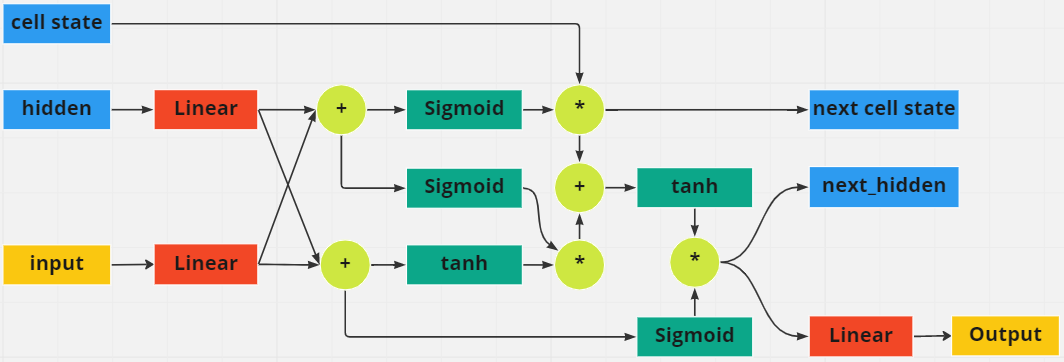

In [2]:
# The architecture of the LSTM is
display.Image('imgs/LSTM_cell.png')

In [3]:
# Just use some short sentence to show how the LSTM embed the sentence
sent = 'How are you today?'
tokens = nltk.word_tokenize(sent)
tokens_dict = {i:t for t, i in enumerate(tokens)}

emb_sent = []
for w in tokens:
    emb_sent.append(torch.tensor(tokens_dict[w], dtype=torch.float32).view(1, -1))
sent_size = len(emb_sent)

inputs = torch.cat(emb_sent).view(sent_size, 1, -1)
print(inputs)
print(inputs.shape)

tensor([[[0.]],

        [[1.]],

        [[2.]],

        [[3.]],

        [[4.]]])
torch.Size([5, 1, 1])


In [4]:
# Set the target tensor for a simple training
target = torch.tensor([0, 0, 1, 0, 0], dtype=torch.float32)

In [5]:
# Define parameters
hidden_dim = 10
out_dim = 5
n_layers = 1
batch_size = 1

# Define the LSTM cell 
# Feed the LSTM model with the whole input, thus the input size is 1 = inputs.shape[-1]
lstm = torch.nn.LSTM(inputs.shape[-1], hidden_dim, n_layers, batch_first=True)
linear = torch.nn.Linear(hidden_dim, out_dim)

# Initialize the hidden state and cell state
hidden_state = torch.randn(n_layers, sent_size, hidden_dim) 
cell_state = torch.randn(n_layers, sent_size, hidden_dim)
hidden = (hidden_state, cell_state)

# Feed the sentence to the lstm network
out, hidden = lstm(inputs, hidden)
# out = out.squeeze()[-1, :]
out = linear(out.squeeze()[-1, :])
print(target)
print(out)

tensor([0., 0., 1., 0., 0.])
tensor([-0.0049, -0.1212, -0.0966,  0.2330, -0.0797], grad_fn=<AddBackward0>)


In [6]:
params = [p for p in lstm.parameters()]
for p in params:
    p.requires_grad = True

n_params = sum(p.nelement() for p in params)
print(f'Total number of parameters {n_params}')

Total number of parameters 520


In [7]:
loss = torch.nn.functional.mse_loss(out, target)
print(f'Loss={loss.item():.4f}')

Loss=0.2556


In [8]:
for i in range(50):
    out, hidden = lstm(inputs, hidden)
    out = linear(out.squeeze()[-1, :])

    loss = torch.nn.functional.mse_loss(out, target)

    # Retain graph to continuously compute the gradient in this case
    for p in params:
        p.grad = None
    loss.backward(retain_graph=True)

    for p in params:
        p.data += -0.05 * p.grad

    loss = torch.nn.functional.mse_loss(out, target)
    print(f'{i+1}/{20}: Loss={loss.item():.4f}')

1/20: Loss=0.2041
2/20: Loss=0.1724
3/20: Loss=0.1582
4/20: Loss=0.1511
5/20: Loss=0.1466
6/20: Loss=0.1430
7/20: Loss=0.1397
8/20: Loss=0.1365
9/20: Loss=0.1335
10/20: Loss=0.1305
11/20: Loss=0.1276
12/20: Loss=0.1247
13/20: Loss=0.1220
14/20: Loss=0.1193
15/20: Loss=0.1167
16/20: Loss=0.1143
17/20: Loss=0.1119
18/20: Loss=0.1096
19/20: Loss=0.1074
20/20: Loss=0.1053
21/20: Loss=0.1033
22/20: Loss=0.1014
23/20: Loss=0.0996
24/20: Loss=0.0978
25/20: Loss=0.0961
26/20: Loss=0.0945
27/20: Loss=0.0929
28/20: Loss=0.0914
29/20: Loss=0.0899
30/20: Loss=0.0886
31/20: Loss=0.0872
32/20: Loss=0.0859
33/20: Loss=0.0847
34/20: Loss=0.0835
35/20: Loss=0.0823
36/20: Loss=0.0812
37/20: Loss=0.0801
38/20: Loss=0.0791
39/20: Loss=0.0781
40/20: Loss=0.0771
41/20: Loss=0.0761
42/20: Loss=0.0752
43/20: Loss=0.0743
44/20: Loss=0.0734
45/20: Loss=0.0726
46/20: Loss=0.0718
47/20: Loss=0.0710
48/20: Loss=0.0702
49/20: Loss=0.0694
50/20: Loss=0.0687


In [9]:
out


tensor([-0.1155,  0.0406,  0.5171,  0.1486,  0.2704], grad_fn=<AddBackward0>)

# An example of part-of-tagging from torch

In [10]:
training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

In [11]:
words = []
tags = []
for s, t in training_data:
    words += s
    tags += t

words = list(set(words))
tags = list(set(tags))

word_to_ix = {w:i for i, w in enumerate(words)}
tag_to_ix = {t:i for i, t in enumerate(tags)}
print(word_to_ix)
print(tag_to_ix)

ix_to_tag = {i:t for t, i in tag_to_ix.items()}

{'The': 0, 'dog': 1, 'ate': 2, 'read': 3, 'book': 4, 'apple': 5, 'that': 6, 'Everybody': 7, 'the': 8}
{'V': 0, 'NN': 1, 'DET': 2}


In [12]:
# define a class for applying the model
class LSTMTagger(nn.Module):

    def __init__(self, emb_dim, hidden_dim, vocab_size, out_dim):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, sent):
        embeds = self.embedding(sent)
        lstm_out, _ = self.lstm(embeds.view(len(sent), 1, -1))
        linear_out = self.linear(lstm_out.view(len(sent), -1))
        tag_score = F.log_softmax(linear_out, dim=1)
        return tag_score

In [13]:
EMBEDDING_DIM = 10
HIDDEN_DIM = 20
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [14]:
with torch.no_grad():
    sent = training_data[0][0] # Get the first sentence (an list of words)
    inputs = torch.tensor([word_to_ix[w] for w in sent], dtype=torch.long) # Encode
    print(model(inputs)) # Get the tag score without training 

tensor([[-1.2250, -1.1764, -0.9217],
        [-1.2049, -1.1549, -0.9540],
        [-1.2303, -1.1555, -0.9341],
        [-1.2552, -1.1171, -0.9474],
        [-1.2312, -1.1352, -0.9501]])


In [15]:
MAX_EPOCH = 200
for i in range(MAX_EPOCH):
    print(f'{i+1}/{MAX_EPOCH}:=====================')
    for sent, tag in training_data:
        loss = 0
        model.zero_grad()

        inputs = torch.tensor([word_to_ix[w] for w in sent], dtype=torch.long)
        targets = torch.tensor([tag_to_ix[w] for w in tag], dtype=torch.long)
        # print(targets)

        tag_scores = model(inputs)
        # print(tag_scores)

        loss = loss_function(tag_scores, targets)

        loss.backward()

        optimizer.step()
    
        print(f'Loss={loss.item()}')
    
    print()

1/200:=====================
Loss=1.0779136419296265
Loss=1.1387474536895752

2/200:=====================
Loss=1.0684795379638672
Loss=1.1222425699234009

3/200:=====================
Loss=1.0599242448806763
Loss=1.1069309711456299

4/200:=====================
Loss=1.0520923137664795
Loss=1.0926538705825806

5/200:=====================
Loss=1.0448485612869263
Loss=1.0792722702026367

6/200:=====================
Loss=1.0380772352218628
Loss=1.0666649341583252

7/200:=====================
Loss=1.0316789150238037
Loss=1.054726004600525

8/200:=====================
Loss=1.0255684852600098
Loss=1.043360710144043

9/200:=====================
Loss=1.0196737051010132
Loss=1.0324842929840088

10/200:=====================
Loss=1.013932704925537
Loss=1.0220197439193726

11/200:=====================
Loss=1.0082929134368896
Loss=1.0118969678878784

12/200:=====================
Loss=1.0027096271514893
Loss=1.0020513534545898

13/200:=====================
Loss=0.9971442222595215
Loss=0.9924242496490479

In [16]:
sample = training_data[1]
sent = sample[0]
tags = sample[1]

inputs = torch.tensor([word_to_ix[w] for w in sent], dtype=torch.long) 
pred_seq = model(inputs).argmax(1).tolist()
pred = [ix_to_tag[i] for i in pred_seq]

print(sample[1])
print(pred)

['NN', 'V', 'DET', 'NN']
['NN', 'V', 'DET', 'NN']


# A use case for time serise prediction